TASK-12A: Please use linear (PCA) and nonlinear (LLE, ISOMAP) dimensionality reduction methods using MR metrics to visualize the patients with their different CDRGLOB values/levels to understand whether there are visible patterns. Please first only use the first two dimensions in your visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
     

In [3]:
data = pd.read_excel("CDR_6_MRIfull.xlsx")


In [4]:
from sklearn.decomposition import PCA
X = data.iloc[:,15:]
pca = PCA(2) 
projected = pca.fit_transform(X)

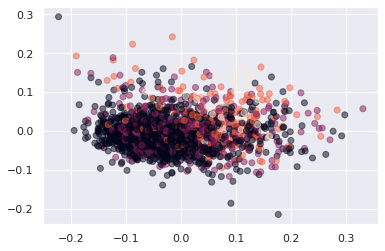

In [6]:
y = data["MEMORY"]
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5, c=y)

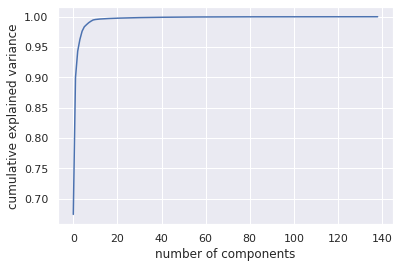

In [7]:
pca_all = PCA().fit(X)
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

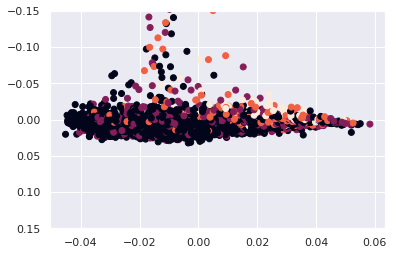

In [8]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], c=y)
ax.set_ylim(0.15, -0.15);
     

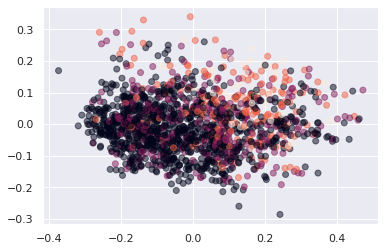

In [9]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
fit = model.fit_transform(X)
plt.scatter(fit[:, 0], fit[:, 1], alpha=0.5, c=y)
     

TASK-12B: Please develop 3 separate predictive models with respect to the datasets with reduced dimensions (but use dimension/component number as 7) in part-A. Then use 3 different algorithms to provide classification models to predict CDRGLOB and compare the outputs of these 9 models. (train-test split = 0.75 and 0.25) 3 algorithms are Gaussian Naive Bayes, SVM (rbf), and RandomForestClassifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import LocallyLinearEmbedding, TSNE

In [12]:
pca = PCA(n_components=7)
fit_data = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(fit_data, data['CDRGLOB'], test_size=0.25, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("GNB Accuracy for PCA:",accuracy_score(y_test, y_pred))

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("SVM Accuracy for PCA:",accuracy_score(y_test, y_pred))

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("RFC Accuracy for PCA:",accuracy_score(y_test, y_pred))
     

GNB Accuracy for PCA: 0.6525
SVM Accuracy for PCA: 0.6625
RFC Accuracy for PCA: 0.655


In [13]:
iso = Isomap(n_components=7)
fit_data = iso.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(fit_data, data['CDRGLOB'], test_size=0.25, random_state=42)

In [15]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("GNB-ISOMAP SCORE:",accuracy_score(y_test, y_pred))
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("SVM-ISOMAP SCORE:",accuracy_score(y_test, y_pred))
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("RFC-ISOMAP SCORE:",accuracy_score(y_test, y_pred))

GNB-ISOMAP SCORE: 0.61
SVM-ISOMAP SCORE: 0.65
RFC-ISOMAP SCORE: 0.6325


TASK-12C: Please combine these four datasets (pca-iso-lle-tsne) and then use an algorithm of your interest separately on this dataset to predict the CDRGLOB values while using grid search to optimize the hyperparameters. Please use the first 5 components from each of these 4 datasets. Please do not forget to apply minmax scaling before the dimensionality reduction operations.



In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

Y=data.iloc[:,15:]

     

In [18]:
pca = PCA(n_components=5)
X_slc_pca = pca.fit_transform(Y)
scaler1 = MinMaxScaler()
scaler1.fit(X_slc_pca)
X_slc_pca = scaler1.transform(X_slc_pca)
     

In [19]:

lle = LocallyLinearEmbedding(n_components=5, n_neighbors=10, method='modified',eigen_solver='dense')
Y_lle = lle.fit_transform(Y)
scaler2 = MinMaxScaler()
scaler2.fit(Y_lle)
Y_lle = scaler2.transform(Y_lle)

In [20]:

Iso = Isomap(n_components=5)
X_slc_ıso = Iso.fit_transform(Y)
scaler3 = MinMaxScaler()
scaler3.fit(X_slc_ıso)
X_slc_ıso = scaler3.transform(X_slc_ıso)

In [22]:
tsne = TSNE(n_components=3, init='random', random_state=0)
X_slc_tsne = tsne.fit_transform(Y)
scaler4 = MinMaxScaler()
scaler4.fit(X_slc_tsne)
X_slc_tsne = scaler4.transform(X_slc_tsne)

In [23]:
arr = np.concatenate((X_slc_pca[:,:5], Y_lle[:,:5], X_slc_ıso[:,:5], X_slc_tsne), axis=1)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestClassifier
param_grid = [{
    'min_samples_split':[2, 3, 4],
    'min_samples_leaf':[2, 3, 4],
    "max_depth": [10, 20, 30]
}]

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True)
grid.fit(X_train, y_train)
grid.best_params_
grid_pred = grid.predict(X_test)

print(accuracy_score(y_test, grid_pred))

0.615


TASK-12D: Please use the new dataset (selected) beginning with the 16th column after scaling it with minmax scaler. Then apply the k-means algorithm on the scaled dataset for k=4 and then visualize it with respect to their labels on 2 dimensions obtained via tSNE.

In [26]:
data2 = pd.read_excel("CDR_6_MRI_selected.xlsx")

In [27]:
Y=data2.iloc[:,15:]

In [28]:
from sklearn.cluster import KMeans

In [29]:
scaler5 = MinMaxScaler()
fit= scaler5.fit_transform(Y)

kmeans = KMeans(n_clusters=4)
kmeans.fit(fit)
y_kmeans = kmeans.predict(fit)

tsne = TSNE(n_components=2)
fitted_data = tsne.fit_transform(fit)


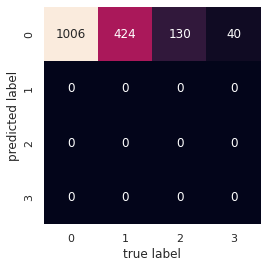

In [30]:
labels = np.zeros_like(y_kmeans)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(data2["CDRGLOB"], labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

TASK-12E: Please use the silhouette algorithm to find the optimal number of clusters (k=2, 3, 4, …. 50). Please visualize the silhouette scores within this range and decide the most appropriate cluster number. Then apply the suitable cluster number using K-means.



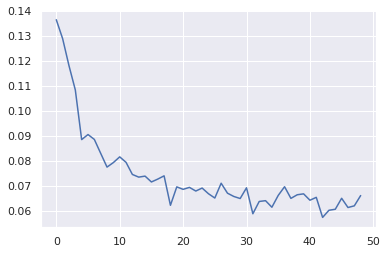

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score
list_SS = []
for no_clusters in range(2,51):

    clusterer = KMeans(n_clusters=no_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(fit)

    silhouette_avg = silhouette_score(fit, cluster_labels)
    list_SS.append(silhouette_avg)
plt.plot(list_SS)
     

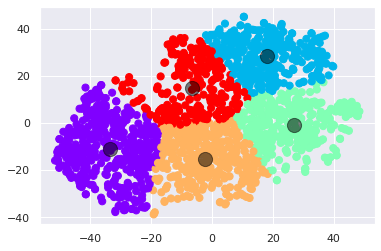

In [32]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(fitted_data)
y_kmeans = kmeans.predict(fitted_data)
    
plt.scatter(fitted_data[:, 0], fitted_data[:, 1], c=y_kmeans, s=50, cmap='rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

TASK-12F: Please use the final dataset but this time add the following columns and then run the model with grid search optimization: SEX INDEPEND NPISCORE FAQ

In [33]:
data3 = data2[['SEX', 'INDEPEND', 'NPISCORE', 'FAQ']]
data4 = np.concatenate((arr, data3), axis = 1)

dfx = pd.DataFrame(data4)


dfx.shape

(1600, 22)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(dfx, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestClassifier
param_grid = [{
    'min_samples_split':[2, 3, 4],
    'min_samples_leaf':[2, 3, 4],
    "max_depth": [10, 20, 30]
}]

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True)
grid.fit(X_train, y_train)
grid.best_params_
grid_pred = grid.predict(X_test)

print(accuracy_score(y_test, grid_pred))

0.7775


TASK-12G: Then for comparison purposes, use only these four columns to develop a model):

SEX INDEPEND NPISCORE FAQ

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data3, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestClassifier
param_grid = [{
    'min_samples_split':[2, 3, 4],
    'min_samples_leaf':[2, 3, 4],
    "max_depth": [10, 20, 30]
}]

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True)
grid.fit(X_train, y_train)
grid.best_params_
grid_pred = grid.predict(X_test)

print(accuracy_score(y_test, grid_pred))
     

0.7675
